# ESMPy regridding with unstructured grids in UGRID formatted files

This example demonstrates how to regrid between a UGRID Triangular Mesh and a logically rectangular Grid. The UGRID file may be retrieved from an OPeNDAP server on the fly. This example uses a static file for the UGRID due to occasional TDS stability issues. The grid file is retrieved from the ESMF data repository using ESMPy utility functions. An ESMF Field with an exact analytic solution is created on the source Mesh, and regridded to the destination regridding using a bilinear method.

In [1]:
# conda create -n esmpy-ugrid-example -c ioos esmpy matplotlib krb5 jupyter netCDF4
# source activate esmpy-ugrid-example
# jupyter notebook

In [2]:
import ESMF
import numpy

Download data files using ESMPy utilities, if they are not downloaded already.

In [3]:
import os
DD = os.path.join(os.getcwd(), "ESMPy-data")
if not os.path.isdir(DD):
    os.makedirs(DD)
from ESMF.util.cache_data import cache_data_file
cache_data_file(os.path.join(DD, "ll1deg_grid.nc"))
# cache_data_file(os.path.join(DD, "aggregAtlanticESTOFS.nc"))
os.system("wget https://www.dropbox.com/s/ke5mdukbjwyqaru/aggregAtlanticESTOFS.nc")
os.system("mv aggregAtlanticESTOFS.nc ESMPy-data")
print('Done.')

Done.


Initialize a global lat/lon grid from a SCRIP formatted file.

In [4]:
gridfile = "ESMPy-data/ll1deg_grid.nc"
grid = ESMF.Grid(filename=gridfile, filetype=ESMF.FileFormat.SCRIP, is_sphere=True)

Create an unstructured mesh from OPeNDAP UGRID formatted regional grid file.

In [5]:
meshfile = "ESMPy-data/aggregAtlanticESTOFS.nc"
mesh = ESMF.Mesh(filename=meshfile, filetype=ESMF.FileFormat.UGRID, meshname='adcirc_mesh')

Create Fields on the NODE locations of the source Mesh, and CENTER locations of the destination Grid.  The source and exact Fields are initialized to a known analytic solution, to allow us to check the error after the regridding operation.

In [6]:
srcfield = ESMF.Field(mesh, name='srcfield', meshloc=ESMF.MeshLoc.NODE)

dstfield = ESMF.Field(grid, name='dstfield', staggerloc=ESMF.StaggerLoc.CENTER)
xctfield = ESMF.Field(grid, name='xctfield', staggerloc=ESMF.StaggerLoc.CENTER)

[lon, lat] = [0, 1]

srcgridXCoord = srcfield.grid.get_coords(lon, meshloc=ESMF.MeshLoc.NODE)
srcgridYCoord = srcfield.grid.get_coords(lat, meshloc=ESMF.MeshLoc.NODE)
srcfield.data[...] = 2.0 + numpy.cos(numpy.radians(srcgridYCoord)[...])**2 * \
                           numpy.cos(2.0*numpy.radians(srcgridXCoord)[...])

dstgridXCoord = xctfield.grid.get_coords(lon, ESMF.StaggerLoc.CENTER)
dstgridYCoord = xctfield.grid.get_coords(lat, ESMF.StaggerLoc.CENTER)
xctfield.data[...] = 2.0 + numpy.cos(numpy.radians(dstgridYCoord)[...])**2 * \
                           numpy.cos(2.0*numpy.radians(dstgridXCoord)[...])

uninitval = 1e20
dstfield.data[...] = uninitval

Create a Regrid object and use it to interpolate from the source to the destination Field. The options to ignore unmapped points leaving uninitialized point values alone has been activated.

In [7]:
regrid = ESMF.Regrid(srcfield, dstfield,
                     regrid_method=ESMF.RegridMethod.BILINEAR,
                     unmapped_action=ESMF.UnmappedAction.IGNORE)

dstfield = regrid(srcfield, dstfield, zero_region=ESMF.Region.SELECT)

Display regridding results and relative error.

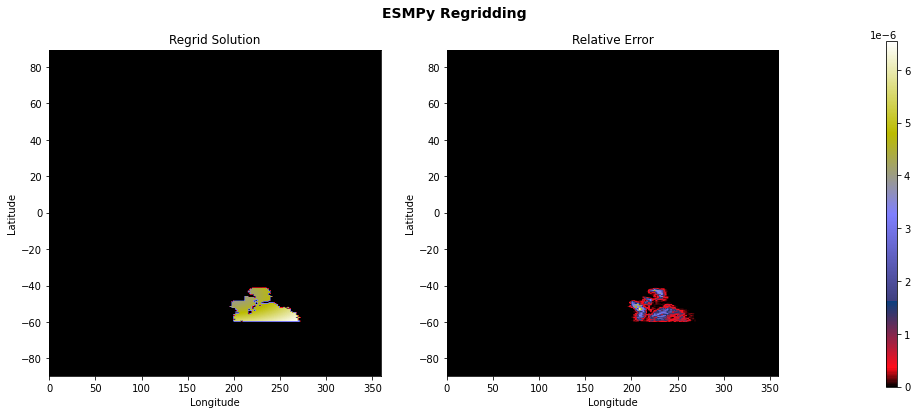

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

colormap = "gist_stern"
lons = dstfield.grid.get_coords(0)
lats = dstfield.grid.get_coords(1)

fig = plt.figure(1, (15, 6))
fig.suptitle('ESMPy Regridding', fontsize=14, fontweight='bold')

ax = fig.add_subplot(1, 2, 1)
solution = numpy.copy(dstfield.data)
solution[numpy.where(dstfield.data == uninitval)] = 0
im = ax.imshow(solution, vmin=numpy.min(solution),
               vmax=numpy.max(solution), cmap=colormap, aspect='auto',
               extent=[numpy.min(lons), numpy.max(lons),
                       numpy.min(lats), numpy.max(lats)])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Regrid Solution")

relerr = numpy.abs(dstfield.data - xctfield.data)/numpy.abs(xctfield.data)
relerr[numpy.where(dstfield.data == uninitval)] = 0
ax = fig.add_subplot(1, 2, 2)
im1 = ax.imshow(relerr, vmin=numpy.min(relerr),
                vmax=numpy.max(relerr), cmap=colormap, aspect='auto',
                extent=[numpy.min(lons), numpy.max(lons),
                        numpy.min(lats), numpy.max(lats)])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Relative Error")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.1, 0.01, 0.8])
fig.colorbar(im1, cax=cbar_ax)

plt.show()

The subplot on the right shows that the ESMF bilinear interpolation method yields a solution with accuracy on the order of 1E-6 using an analytic field of a second order spherical harmonic-like function.  

Using netCDF4 we can now look at a regridded solution using source data from the UGRID file.

In [9]:
import netCDF4 as nc
f = nc.Dataset("ESMPy-data/aggregAtlanticESTOFS.nc")
zeta = f.variables["zeta"]
srcfield.data[...] = zeta[0]
f.close()

The destination field needs to be reinitialized and the regridding needs to be rerun.  Notice how it is not necessary to rebuild the Regrid object if it is being using on a Field pair built on the same underlying Grid/Mesh objects.  This saves the computation time of creating the large sparse interpolation matrix.  It is only necessary to call the Regrid object on the Field pair to reapply the regridding operation using the new data values.

In [10]:
dstfield.data[...] = uninitval

dstfield = regrid(srcfield, dstfield, zero_region=ESMF.Region.SELECT)

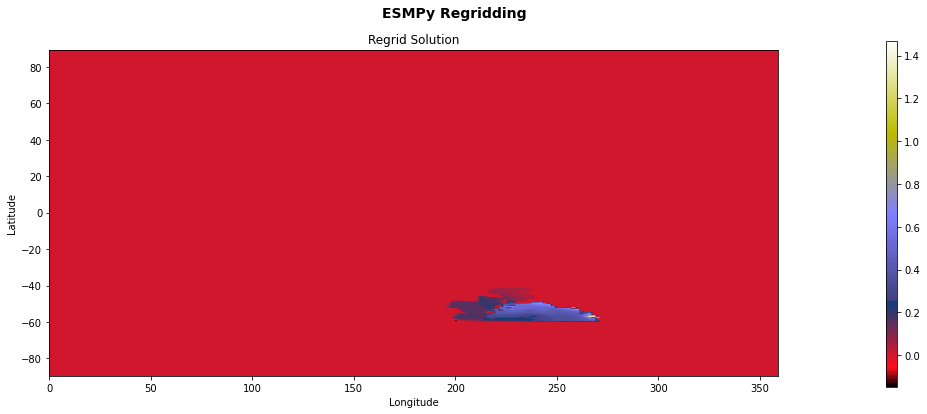

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

colormap = "gist_stern"
lons = dstfield.grid.get_coords(0)
lats = dstfield.grid.get_coords(1)

fig = plt.figure(1, (15, 6))
fig.suptitle('ESMPy Regridding', fontsize=14, fontweight='bold')

solution = numpy.copy(dstfield.data)
solution[numpy.where(dstfield.data == uninitval)] = 0
im = plt.imshow(solution, vmin=numpy.min(solution),
               vmax=numpy.max(solution), cmap=colormap, aspect='auto',
               extent=[numpy.min(lons), numpy.max(lons),
                       numpy.min(lats), numpy.max(lats)])

ax = plt.gca()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Regrid Solution")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.1, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax)

plt.show()